In [2]:
import pickle as pk
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
subreddit = 'tennis'
metadata = pk.load(open(f"./data/samples/{subreddit}-comments.pk", "rb"))
embeddings = pk.load(open(f"./data/output/embeddings/{subreddit}.pk", "rb"))

In [21]:
from emb_regression_I import *

In [22]:
dist, months = dist_for_one_sample(metadata, embeddings)
dist_res, rank_res = run_regression(dist, months)

Optimization terminated successfully.
         Current function value: 3.889514
         Iterations: 340
         Function evaluations: 362
         Gradient evaluations: 362


In [23]:
dist_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    emb   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     42.84
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          6.32e-309
Time:                        19:33:32   Log-Likelihood:                 8370.8
No. Observations:                2902   AIC:                        -1.664e+04
Df Residuals:                    2850   BIC:                        -1.633e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0090      0.002      4.400      0.000       0.005       0.013
C(month_1_year)[T.2015]    -0.0090      0.001    -11.164      0.000      -0.011      -0.007
C(month_1_year)[T.2016]    -0.0097      0.001    -12.094      0.000      -0.011      -0.008
C(month_1_year)[T.2017]    -0.0144      0.001    -17.699      0.000      -0.016      -0.013
C(month_1_year)[T.2018]    -0.0146      0.001    -16.025      0.000      -0.016      -0.013
C(month_1_month)[T.02]      0.0047      0.001      3.809      0.000       0.002       0.007
C(month_1_month)[T.03]      0.0016      0.001      1.344      0.179      -0.001       0.004
C(month_1_month)[T.04]      0.0029      0.001      2.381      0.017       0.001       0.005
C(month_1_month)[T.05]     -0.0044      0.001     -3.630      0.000      -0.007      -0.002
C(month_1_month)[T.06]     -0.0059      0.001     -4.850      0.000      -0.008      -0.004
C(month_1_month)[T.07]     -0.0026      0.001     -2.145      0.032      -0.005      -0.000
C(month_1_month)[T.08]     -0.0048      0.001     -3.953      0.000      -0.007      -0.002
C(month_1_month)[T.09]     -0.0004      0.001     -0.300      0.764      -0.003       0.002
C(month_1_month)[T.10]      0.0013      0.001      1.063      0.288      -0.001       0.004
C(month_1_month)[T.11]     -0.0016      0.001     -1.268      0.205      -0.004       0.001
C(month_1_month)[T.12]      0.0167      0.001     12.954      0.000       0.014       0.019
C(n_months)[T.1]            0.0551      0.002     25.025      0.000       0.051       0.059
C(n_months)[T.2]            0.0505      0.002     22.895      0.000       0.046       0.055
C(n_months)[T.3]            0.0570      0.002     25.745      0.000       0.053       0.061
C(n_months)[T.4]            0.0529      0.002     23.830      0.000       0.049       0.057
C(n_months)[T.5]            0.0567      0.002     25.455      0.000       0.052       0.061
C(n_months)[T.6]            0.0533      0.002     23.850      0.000       0.049       0.058
C(n_months)[T.7]            0.0560      0.002     24.939      0.000       0.052       0.060
C(n_months)[T.8]            0.0527      0.002     23.378      0.000       0.048       0.057
C(n_months)[T.9]            0.0576      0.002     25.486      0.000       0.053       0.062
C(n_months)[T.10]           0.0532      0.002     23.428      0.000       0.049       0.058
C(n_months)[T.11]           0.0564      0.002     24.736      0.000       0.052       0.061
C(n_months)[T.12]           0.0474      0.002     20.696      0.000       0.043       0.052
C(n_months)[T.13]           0.0567      0.002     24.657      0.000       0.052       0.061
C(n_months)[T.14]           0.0542      0.002     23.493      0.000       0.050       0.059
C(n_months)[T.15]           0.0598      0.002  

In [25]:
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.miscmodels.ordinal_model import OrderedModel

sample_idx = np.random.choice(len(embeddings), size=50000, replace=True)
sample_meta = metadata[sample_idx]
sample_emb = embeddings[sample_idx, :]
monthly_emb = pd.DataFrame(sample_emb).groupby([x['year-month'] for x in sample_meta]).mean()
dist = euclidean_distances(monthly_emb.values)

In [28]:

# np.fill_diagonal(dist, np.nan)
months = list(monthly_emb.index)
dist_df = pd.DataFrame(dist, index=months)
dist_df.columns = months
long = dist_df.unstack().reset_index()
long = long.sort_values(["level_0", "level_1"])
long = long.rename({"level_0": "month_1", "level_1": "month_2", 0: "emb"}, axis=1)
long['emb_rank'] = long.groupby("month_1")["emb"].rank()

long["n_months"] = np.abs((pd.to_datetime(long["month_2"]).dt.to_period("M") - pd.to_datetime(long["month_1"]).dt.to_period("M")).apply(lambda x: x.n))
long = long[long['n_months'] <= 36].copy()

month2seq = dict(zip(months, range(len(months))))
long['month_1_numeric'] = long['month_1'].apply(lambda t: month2seq[t])

In [29]:
long

,month_1,month_2,emb,emb_rank,n_months,month_1_numeric
0,2014-01,2014-01,0.000000,1.0,0,0
1,2014-01,2014-02,0.105524,58.0,1,0
2,2014-01,2014-03,0.068024,49.0,2,0
3,2014-01,2014-04,0.087218,57.0,3,0
4,2014-01,2014-05,0.069458,50.0,4,0
...,...,...,...,...,...,...
3359,2018-10,2018-06,0.035090,6.0,4,57
3360,2018-10,2018-07,0.048406,30.0,3,57
3361,2018-10,2018-08,0.036086,9.0,2,57
3362,2018-10,2018-09,0.066508,50.0,1,57


In [30]:
mod = smf.ols(formula='emb ~ C(n_months) + month_1_numeric', data=long.dropna())
dist_res = mod.fit()

In [22]:
mod = smf.ols(formula='emb ~ C(n_months) + month_1_ts', data=long.dropna())
dist_res = mod.fit()

In [23]:
dist_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    emb   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     30.49
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          2.27e-260
Time:                        18:59:40   Log-Likelihood:                 9378.1
No. Observations:                3364   AIC:                        -1.864e+04
Df Residuals:                    3305   BIC:                        -1.828e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1312      0.009     14.851      0.000       0.114       0.149
C(n_months)[T.1]      0.0537      0.002     22.160      0.000       0.049       0.058
C(n_months)[T.2]      0.0499      0.002     20.515      0.000       0.045       0.055
C(n_months)[T.3]      0.0544      0.002     22.323      0.000       0.050       0.059
C(n_months)[T.4]      0.0520      0.002     21.243      0.000       0.047       0.057
C(n_months)[T.5]      0.0544      0.002     22.165      0.000       0.050       0.059
C(n_months)[T.6]      0.0515      0.002     20.893      0.000       0.047       0.056
C(n_months)[T.7]      0.0548      0.002     22.177      0.000       0.050       0.060
C(n_months)[T.8]      0.0516      0.002     20.791      0.000       0.047       0.056
C(n_months)[T.9]      0.0554      0.002     22.268      0.000       0.051       0.060
C(n_months)[T.10]     0.0510      0.002     20.423      0.000       0.046       0.056
C(n_months)[T.11]     0.0542      0.003     21.612      0.000       0.049       0.059
C(n_months)[T.12]     0.0467      0.003     18.521      0.000       0.042       0.052
C(n_months)[T.13]     0.0547      0.003     21.598      0.000       0.050       0.060
C(n_months)[T.14]     0.0530      0.003     20.852      0.000       0.048       0.058
C(n_months)[T.15]     0.0583      0.003     22.815      0.000       0.053       0.063
C(n_months)[T.16]     0.0548      0.003     21.379      0.000       0.050       0.060
C(n_months)[T.17]     0.0585      0.003     22.689      0.000       0.053       0.064
C(n_months)[T.18]     0.0560      0.003     21.596      0.000       0.051       0.061
C(n_months)[T.19]     0.0591      0.003     22.692      0.000       0.054       0.064
C(n_months)[T.20]     0.0568      0.003     21.692      0.000       0.052       0.062
C(n_months)[T.21]     0.0600      0.003     22.772      0.000       0.055       0.065
C(n_months)[T.22]     0.0557      0.003     21.026      0.000       0.051       0.061
C(n_months)[T.23]     0.0585      0.003     21.941      0.000       0.053       0.064
C(n_months)[T.24]     0.0521      0.003     19.408      0.000       0.047       0.057
C(n_months)[T.25]     0.0592      0.003     21.892      0.000       0.054       0.065
C(n_months)[T.26]     0.0579      0.003     21.256      0.000       0.053       0.063
C(n_months)[T.27]     0.0635      0.003     23.126      0.000       0.058       0.069
C(n_months)[T.28]     0.0601      0.003     21.731      0.000       0.055       0.066
C(n_months)[T.29]     0.0635      0.003     22.768      0.000       0.058       0.069
C(n_months)[T.30]     0.0604      0.003     21.470      0.000       0.055       0.066
C(n_months)[T.31]     0.0634      0.003     22.293      0.000       0.058       0.069
C(n_months)[T.32]     0.0613      0.003     21.352      0.000       0.056

In [ ]:
mod = OrderedModel.from_formula("emb_rank ~ C(n_months)", data=long.dropna(),
                                distr='logit')
rank_res = mod.fit(method='bfgs')


In [42]:
rank_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               emb_rank   Log-Likelihood:                -12926.
Model:                   OrderedModel   AIC:                         2.608e+04
Method:            Maximum Likelihood   BIC:                         2.676e+04
Date:                Mon, 27 Feb 2023                                         
Time:                        15:29:08                                         
No. Observations:                3306                                         
Df Residuals:                    3194                                         
Df Model:                         112                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
C(n_months)[T.2]      1.0617      0.238      4.455      0.000       0.595       1.529
C(n_months)[T.3]      1.9531      0.243      8.046      0.000       1.477       2.429
C(n_months)[T.4]      2.3126      0.240      9.638      0.000       1.842       2.783
C(n_months)[T.5]      2.6444      0.242     10.923      0.000       2.170       3.119
C(n_months)[T.6]      2.8118      0.245     11.475      0.000       2.332       3.292
C(n_months)[T.7]      2.8253      0.246     11.488      0.000       2.343       3.307
C(n_months)[T.8]      2.6098      0.242     10.797      0.000       2.136       3.084
C(n_months)[T.9]      2.1561      0.246      8.763      0.000       1.674       2.638
C(n_months)[T.10]     1.2752      0.247      5.164      0.000       0.791       1.759
C(n_months)[T.11]     0.4862      0.254      1.915      0.056      -0.012       0.984
C(n_months)[T.12]     0.0456      0.252      0.181      0.856      -0.448       0.539
C(n_months)[T.13]     0.1124      0.253      0.444      0.657      -0.383       0.608
C(n_months)[T.14]     1.0977      0.256      4.296      0.000       0.597       1.599
C(n_months)[T.15]     1.9223      0.260      7.398      0.000       1.413       2.432
C(n_months)[T.16]     2.4179      0.256      9.452      0.000       1.916       2.919
C(n_months)[T.17]     2.6401      0.260     10.141      0.000       2.130       3.150
C(n_months)[T.18]     2.7772      0.259     10.714      0.000       2.269       3.285
C(n_months)[T.19]     2.8091      0.262     10.722      0.000       2.296       3.323
C(n_months)[T.20]     2.6928      0.261     10.312      0.000       2.181       3.205
C(n_months)[T.21]     2.1613      0.262      8.260      0.000       1.648       2.674
C(n_months)[T.22]     1.5633      0.260      6.011      0.000       1.054       2.073
C(n_months)[T.23]     0.8658      0.273      3.168      0.002       0.330       1.401
C(n_months)[T.24]     0.5387      0.276      1.949      0.051      -0.003       1.080
C(n_months)[T.25]     0.7427      0.276      2.692      0.007       0.202       1.283
C(n_months)[T.26]     0.9991      0.272      3.679      0.000       0.467       1.531
C(n_months)[T.27]     1.8810      0.280      6.713      0.000       1.332       2.430
C(n_months)[T.28]     2.5415      0.293      8.668      0.000       1.967       3.116
C(n_months)[T.29]     3.0132      0.291     10.368      0.000       2.444       3.583
C(n_months)[T.30]     3.2574      0.291     11.176      0.000       2.686       3.829
C(n_months)[T.31]     3.0355      0.294     10.342      0.000       2.460       3.611
C(n_months)[T.32]     2.7158      0.287      9.462      0.000       2.153       3.278
C(n_months)[T.33]     2.2262      0.298      7.467      0.000       1.642       2.811
C(n_months)[T.34]     1.5731      0.315      4.999      0.000       0.956       2.190
C(n_months)[T.35]     0.9356      0.311      3.003      0.003     

In [43]:
dist_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         normalized_emb   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     14.04
Date:                Mon, 27 Feb 2023   Prob (F-statistic):          4.67e-114
Time:                        15:29:38   Log-Likelihood:                 1126.3
No. Observations:                3306   AIC:                            -2139.
Df Residuals:                    3249   BIC:                            -1791.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3125      0.016     19.221      0.000       0.281       0.344
C(n_months)[T.2]      0.0854      0.023      3.698      0.000       0.040       0.131
C(n_months)[T.3]      0.1591      0.023      6.856      0.000       0.114       0.205
C(n_months)[T.4]      0.1980      0.023      8.493      0.000       0.152       0.244
C(n_months)[T.5]      0.2325      0.023      9.923      0.000       0.187       0.278
C(n_months)[T.6]      0.2433      0.024     10.335      0.000       0.197       0.289
C(n_months)[T.7]      0.2453      0.024     10.368      0.000       0.199       0.292
C(n_months)[T.8]      0.2191      0.024      9.211      0.000       0.172       0.266
C(n_months)[T.9]      0.1756      0.024      7.341      0.000       0.129       0.222
C(n_months)[T.10]     0.1012      0.024      4.209      0.000       0.054       0.148
C(n_months)[T.11]     0.0387      0.024      1.600      0.110      -0.009       0.086
C(n_months)[T.12]     0.0112      0.024      0.461      0.645      -0.036       0.059
C(n_months)[T.13]     0.0232      0.024      0.948      0.343      -0.025       0.071
C(n_months)[T.14]     0.0997      0.025      4.046      0.000       0.051       0.148
C(n_months)[T.15]     0.1681      0.025      6.780      0.000       0.120       0.217
C(n_months)[T.16]     0.2128      0.025      8.526      0.000       0.164       0.262
C(n_months)[T.17]     0.2267      0.025      9.016      0.000       0.177       0.276
C(n_months)[T.18]     0.2379      0.025      9.396      0.000       0.188       0.288
C(n_months)[T.19]     0.2310      0.026      9.053      0.000       0.181       0.281
C(n_months)[T.20]     0.2212      0.026      8.602      0.000       0.171       0.272
C(n_months)[T.21]     0.1774      0.026      6.847      0.000       0.127       0.228
C(n_months)[T.22]     0.1133      0.026      4.337      0.000       0.062       0.165
C(n_months)[T.23]     0.0630      0.026      2.390      0.017       0.011       0.115
C(n_months)[T.24]     0.0400      0.027      1.505      0.132      -0.012       0.092
C(n_months)[T.25]     0.0571      0.027      2.128      0.033       0.004       0.110
C(n_months)[T.26]     0.1019      0.027      3.758      0.000       0.049       0.155
C(n_months)[T.27]     0.1663      0.027      6.072      0.000       0.113       0.220
C(n_months)[T.28]     0.2260      0.028      8.162      0.000       0.172       0.280
C(n_months)[T.29]     0.2676      0.028      9.557      0.000       0.213       0.323
C(n_months)[T.30]     0.2799      0.028      9.878      0.000       0.224       0.335
C(n_months)[T.31]     0.2666      0.029      9.295      0.000       0.210       0.323
C(n_months)[T.32]     0.2282      0.029      7.855      0.000       0.171       0.285
C(n_months)[T.33]     0.1855      0.029      6.298      0.000       0.128

In [53]:
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing

def dist_for_one_sample(metadata, embeddings):
    sample_idx = np.random.choice(len(embeddings), size=50000, replace=True)
    sample_meta = metadata[sample_idx]
    sample_emb = embeddings[sample_idx, :]
    monthly_emb = pd.DataFrame(sample_emb).groupby([x['year-month'] for x in sample_meta]).mean()
    dist = euclidean_distances(monthly_emb.values)
    np.fill_diagonal(dist, np.nan)
    months = list(monthly_emb.index)
    
    return dist

def run_regression(dist):
    dist_df = pd.DataFrame(dist, index=months)
    dist_df.columns = months
    long = dist_df.unstack().reset_index()
    long = long.sort_values(["level_0", "level_1"])
    long = long.rename({"level_0": "month_1", "level_1": "month_2", 0: "emb"}, axis=1)
    long['emb_rank'] = long.groupby("month_1")["emb"].rank()
    long['same_year'] = long.apply(lambda r: 1 if r['month_1'].split("-")[0] == r['month_2'].split("-")[0] else 0,
                                       axis=1)
    long['same_month'] = long.apply(lambda r: 1 if r['month_1'].split("-")[1] == r['month_2'].split("-")[1] else 0,
                                        axis=1)
    long["n_months"] = np.abs((pd.to_datetime(long["month_2"]).dt.to_period("M") - pd.to_datetime(long["month_1"]).dt.to_period("M")).apply(lambda x: x.n))
    
    long = long[long['n_months'] <= 36]
    
#     scaler = preprocessing.MinMaxScaler()
#     norms = scaler.fit_transform(long[['emb', 'emb_rank']].values)
#     long['normalized_emb'] = norms[:, 0]
#     long['normalized_emb_rank'] = norms[:, 1]
    
    mod = smf.ols(formula='emb ~ C(n_months)', data=long.dropna())
    dist_res = mod.fit()

    mod = OrderedModel.from_formula("emb_rank ~ C(n_months)", data=long.dropna(),
                                    distr='logit')

    rank_res = mod.fit(method='bfgs')
    return dist_res, rank_res

In [7]:
long = long[long['n_months'] <= 36]

In [16]:
mod = smf.ols(formula='emb ~ C(n_months)', data=long.dropna())
dist_res = mod.fit()

In [20]:
dist_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    emb   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     18.46
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          5.92e-101
Time:                        00:28:40   Log-Likelihood:                 8848.7
No. Observations:                2844   AIC:                        -1.763e+04
Df Residuals:                    2808   BIC:                        -1.741e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0431      0.001     42.421      0.000       0.041       0.045
C(n_months)[T.2]      0.0048      0.001      3.319      0.001       0.002       0.008
C(n_months)[T.3]      0.0092      0.001      6.345      0.000       0.006       0.012
C(n_months)[T.4]      0.0120      0.001      8.239      0.000       0.009       0.015
C(n_months)[T.5]      0.0142      0.001      9.702      0.000       0.011       0.017
C(n_months)[T.6]      0.0152      0.001     10.369      0.000       0.012       0.018
C(n_months)[T.7]      0.0144      0.001      9.710      0.000       0.011       0.017
C(n_months)[T.8]      0.0127      0.001      8.522      0.000       0.010       0.016
C(n_months)[T.9]      0.0094      0.001      6.294      0.000       0.006       0.012
C(n_months)[T.10]     0.0060      0.002      3.976      0.000       0.003       0.009
C(n_months)[T.11]     0.0022      0.002      1.457      0.145      -0.001       0.005
C(n_months)[T.12]     0.0002      0.002      0.114      0.909      -0.003       0.003
C(n_months)[T.13]     0.0019      0.002      1.239      0.215      -0.001       0.005
C(n_months)[T.14]     0.0058      0.002      3.738      0.000       0.003       0.009
C(n_months)[T.15]     0.0100      0.002      6.483      0.000       0.007       0.013
C(n_months)[T.16]     0.0129      0.002      8.257      0.000       0.010       0.016
C(n_months)[T.17]     0.0145      0.002      9.239      0.000       0.011       0.018
C(n_months)[T.18]     0.0145      0.002      9.171      0.000       0.011       0.018
C(n_months)[T.19]     0.0147      0.002      9.241      0.000       0.012       0.018
C(n_months)[T.20]     0.0132      0.002      8.211      0.000       0.010       0.016
C(n_months)[T.21]     0.0102      0.002      6.329      0.000       0.007       0.013
C(n_months)[T.22]     0.0064      0.002      3.950      0.000       0.003       0.010
C(n_months)[T.23]     0.0032      0.002      1.924      0.054   -6.05e-05       0.006
C(n_months)[T.24]     0.0025      0.002      1.479      0.139      -0.001       0.006
C(n_months)[T.25]     0.0029      0.002      1.754      0.080      -0.000       0.006
C(n_months)[T.26]     0.0059      0.002      3.479      0.001       0.003       0.009
C(n_months)[T.27]     0.0102      0.002      5.981      0.000       0.007       0.014
C(n_months)[T.28]     0.0131      0.002      7.577      0.000       0.010       0.017
C(n_months)[T.29]     0.0164      0.002      9.362      0.000       0.013       0.020
C(n_months)[T.30]     0.0170      0.002      9.579      0.000       0.013       0.020
C(n_months)[T.31]     0.0170      0.002      9.498      0.000       0.014       0.021
C(n_months)[T.32]     0.0145      0.002      8.007      0.000       0.011       0.018
C(n_months)[T.33]     0.0123      0.002      6.673      0.000       0.009

In [17]:
x = long.dropna().drop_duplicates(subset = ["emb", "n_months"])
mod = smf.ols(formula='emb ~ C(n_months)', data=x)
dist_res2 = mod.fit()

In [21]:
dist_res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    emb   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     9.112
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           5.40e-42
Time:                        00:28:46   Log-Likelihood:                 4424.3
No. Observations:                1422   AIC:                            -8777.
Df Residuals:                    1386   BIC:                            -8587.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0431      0.001     29.803      0.000       0.040       0.046
C(n_months)[T.2]      0.0048      0.002      2.332      0.020       0.001       0.009
C(n_months)[T.3]      0.0092      0.002      4.458      0.000       0.005       0.013
C(n_months)[T.4]      0.0120      0.002      5.789      0.000       0.008       0.016
C(n_months)[T.5]      0.0142      0.002      6.816      0.000       0.010       0.018
C(n_months)[T.6]      0.0152      0.002      7.285      0.000       0.011       0.019
C(n_months)[T.7]      0.0144      0.002      6.822      0.000       0.010       0.018
C(n_months)[T.8]      0.0127      0.002      5.987      0.000       0.009       0.017
C(n_months)[T.9]      0.0094      0.002      4.422      0.000       0.005       0.014
C(n_months)[T.10]     0.0060      0.002      2.793      0.005       0.002       0.010
C(n_months)[T.11]     0.0022      0.002      1.023      0.306      -0.002       0.006
C(n_months)[T.12]     0.0002      0.002      0.080      0.936      -0.004       0.004
C(n_months)[T.13]     0.0019      0.002      0.871      0.384      -0.002       0.006
C(n_months)[T.14]     0.0058      0.002      2.626      0.009       0.001       0.010
C(n_months)[T.15]     0.0100      0.002      4.555      0.000       0.006       0.014
C(n_months)[T.16]     0.0129      0.002      5.801      0.000       0.009       0.017
C(n_months)[T.17]     0.0145      0.002      6.491      0.000       0.010       0.019
C(n_months)[T.18]     0.0145      0.002      6.444      0.000       0.010       0.019
C(n_months)[T.19]     0.0147      0.002      6.493      0.000       0.010       0.019
C(n_months)[T.20]     0.0132      0.002      5.768      0.000       0.009       0.018
C(n_months)[T.21]     0.0102      0.002      4.447      0.000       0.006       0.015
C(n_months)[T.22]     0.0064      0.002      2.775      0.006       0.002       0.011
C(n_months)[T.23]     0.0032      0.002      1.352      0.177      -0.001       0.008
C(n_months)[T.24]     0.0025      0.002      1.039      0.299      -0.002       0.007
C(n_months)[T.25]     0.0029      0.002      1.232      0.218      -0.002       0.008
C(n_months)[T.26]     0.0059      0.002      2.444      0.015       0.001       0.011
C(n_months)[T.27]     0.0102      0.002      4.202      0.000       0.005       0.015
C(n_months)[T.28]     0.0131      0.002      5.324      0.000       0.008       0.018
C(n_months)[T.29]     0.0164      0.002      6.577      0.000       0.011       0.021
C(n_months)[T.30]     0.0170      0.003      6.730      0.000       0.012       0.022
C(n_months)[T.31]     0.0170      0.003      6.673      0.000       0.012       0.022
C(n_months)[T.32]     0.0145      0.003      5.626      0.000       0.009       0.020
C(n_months)[T.33]     0.0123      0.003      4.688      0.000       0.007

In [15]:
x[x['month_1'] == "2018-01"]

,month_1,month_2,emb,emb_rank,same_year,same_month,n_months
2833,2018-01,2018-02,0.058733,53.0,1,0,1
2834,2018-01,2018-03,0.040596,22.0,1,0,2
2835,2018-01,2018-04,0.038161,16.0,1,0,3
2836,2018-01,2018-05,0.056426,50.0,1,0,4
2837,2018-01,2018-06,0.057877,52.0,1,0,5
2838,2018-01,2018-07,0.046295,33.0,1,0,6
2839,2018-01,2018-08,0.043725,26.0,1,0,7
2840,2018-01,2018-09,0.046035,31.0,1,0,8
2841,2018-01,2018-10,0.038467,18.0,1,0,9


In [9]:
long[long['month_1'] == "2018-01"]

,month_1,month_2,emb,emb_rank,same_year,same_month,n_months
2796,2018-01,2015-01,0.034776,12.0,0,1,36
2797,2018-01,2015-02,0.035701,15.0,0,0,35
2798,2018-01,2015-03,0.048215,38.0,0,0,34
2799,2018-01,2015-04,0.070231,56.0,0,0,33
2800,2018-01,2015-05,0.055515,49.0,0,0,32
2801,2018-01,2015-06,0.067675,55.0,0,0,31
2802,2018-01,2015-07,0.046335,34.0,0,0,30
2803,2018-01,2015-08,0.053428,45.0,0,0,29
2804,2018-01,2015-09,0.046422,35.0,0,0,28
2805,2018-01,2015-10,0.043686,25.0,0,0,27


In [54]:
from tqdm import tqdm
dist_params = list()
rank_params = list()

for i in tqdm(range(300)):
    dist_res, rank_res = run(metadata, embeddings)

    for k, v in dist_res.params.to_dict().items():
        dist_params.append({"variable": k, "coefficient": v, "pvalue": dist_res.pvalues[k]})

    for k, v in rank_res.params.to_dict().items():
        rank_params.append({"variable": k, "coefficient": v, "pvalue": rank_res.pvalues[k]})

  0%|                                                                                                                                                                                | 0/300 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 3.906323
         Iterations: 225
         Function evaluations: 229
         Gradient evaluations: 229


  0%|▌                                                                                                                                                                     | 1/300 [00:32<2:41:47, 32.47s/it]

Optimization terminated successfully.
         Current function value: 3.918720
         Iterations: 225
         Function evaluations: 228
         Gradient evaluations: 228


  1%|█                                                                                                                                                                     | 2/300 [01:04<2:39:54, 32.20s/it]

Optimization terminated successfully.
         Current function value: 3.906186
         Iterations: 241
         Function evaluations: 245
         Gradient evaluations: 245


  1%|█▋                                                                                                                                                                    | 3/300 [01:37<2:41:28, 32.62s/it]

Optimization terminated successfully.
         Current function value: 3.913484
         Iterations: 225
         Function evaluations: 229
         Gradient evaluations: 229


  1%|██▏                                                                                                                                                                   | 4/300 [02:09<2:38:55, 32.21s/it]

Optimization terminated successfully.
         Current function value: 3.905910
         Iterations: 223
         Function evaluations: 227
         Gradient evaluations: 227


  2%|██▊                                                                                                                                                                   | 5/300 [02:40<2:37:14, 31.98s/it]

Optimization terminated successfully.
         Current function value: 3.918681
         Iterations: 218
         Function evaluations: 222
         Gradient evaluations: 222


  2%|███▎                                                                                                                                                                  | 6/300 [03:11<2:35:16, 31.69s/it]

Optimization terminated successfully.
         Current function value: 3.908404
         Iterations: 224
         Function evaluations: 228
         Gradient evaluations: 228


  2%|███▊                                                                                                                                                                  | 7/300 [03:43<2:34:53, 31.72s/it]

Optimization terminated successfully.
         Current function value: 3.915655
         Iterations: 226
         Function evaluations: 229
         Gradient evaluations: 229


  3%|████▍                                                                                                                                                                 | 8/300 [04:15<2:34:27, 31.74s/it]

Optimization terminated successfully.
         Current function value: 3.929412
         Iterations: 218
         Function evaluations: 222
         Gradient evaluations: 222


  3%|████▉                                                                                                                                                                 | 9/300 [04:46<2:33:15, 31.60s/it]

Optimization terminated successfully.
         Current function value: 3.932816
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


  3%|█████▌                                                                                                                                                               | 10/300 [05:18<2:33:03, 31.67s/it]

Optimization terminated successfully.
         Current function value: 3.912632
         Iterations: 228
         Function evaluations: 232
         Gradient evaluations: 232


  4%|██████                                                                                                                                                               | 11/300 [05:50<2:33:10, 31.80s/it]

Optimization terminated successfully.
         Current function value: 3.912705
         Iterations: 227
         Function evaluations: 231
         Gradient evaluations: 231


  4%|██████▌                                                                                                                                                              | 12/300 [06:22<2:32:44, 31.82s/it]

Optimization terminated successfully.
         Current function value: 3.931441
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


  4%|███████▏                                                                                                                                                             | 13/300 [06:54<2:32:20, 31.85s/it]

Optimization terminated successfully.
         Current function value: 3.904557
         Iterations: 224
         Function evaluations: 228
         Gradient evaluations: 228


  5%|███████▋                                                                                                                                                             | 14/300 [07:26<2:31:34, 31.80s/it]

Optimization terminated successfully.
         Current function value: 3.918962
         Iterations: 228
         Function evaluations: 232
         Gradient evaluations: 232


  5%|████████▎                                                                                                                                                            | 15/300 [07:58<2:31:35, 31.92s/it]

Optimization terminated successfully.
         Current function value: 3.923951
         Iterations: 227
         Function evaluations: 231
         Gradient evaluations: 231


  5%|████████▊                                                                                                                                                            | 16/300 [08:31<2:32:40, 32.26s/it]

Optimization terminated successfully.
         Current function value: 3.930482
         Iterations: 224
         Function evaluations: 228
         Gradient evaluations: 228


  6%|█████████▎                                                                                                                                                           | 17/300 [09:03<2:31:30, 32.12s/it]

Optimization terminated successfully.
         Current function value: 3.903494
         Iterations: 229
         Function evaluations: 233
         Gradient evaluations: 233


  6%|█████████▉                                                                                                                                                           | 18/300 [09:35<2:31:27, 32.23s/it]

Optimization terminated successfully.
         Current function value: 3.911117
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


  6%|██████████▍                                                                                                                                                          | 19/300 [10:07<2:30:27, 32.13s/it]

Optimization terminated successfully.
         Current function value: 3.900258
         Iterations: 218
         Function evaluations: 222
         Gradient evaluations: 222


  7%|███████████                                                                                                                                                          | 20/300 [10:38<2:28:45, 31.88s/it]

Optimization terminated successfully.
         Current function value: 3.890698
         Iterations: 228
         Function evaluations: 232
         Gradient evaluations: 232


  7%|███████████▌                                                                                                                                                         | 21/300 [11:11<2:28:39, 31.97s/it]

Optimization terminated successfully.
         Current function value: 3.920758
         Iterations: 220
         Function evaluations: 224
         Gradient evaluations: 224


  7%|████████████                                                                                                                                                         | 22/300 [11:42<2:27:24, 31.82s/it]

Optimization terminated successfully.
         Current function value: 3.913568
         Iterations: 237
         Function evaluations: 241
         Gradient evaluations: 241


  8%|████████████▋                                                                                                                                                        | 23/300 [12:15<2:28:33, 32.18s/it]

Optimization terminated successfully.
         Current function value: 3.908408
         Iterations: 218
         Function evaluations: 222
         Gradient evaluations: 222


  8%|█████████████▏                                                                                                                                                       | 24/300 [12:46<2:26:35, 31.87s/it]

Optimization terminated successfully.
         Current function value: 3.904227
         Iterations: 224
         Function evaluations: 227
         Gradient evaluations: 227


  8%|█████████████▊                                                                                                                                                       | 25/300 [13:18<2:25:57, 31.85s/it]

Optimization terminated successfully.
         Current function value: 3.921415
         Iterations: 228
         Function evaluations: 232
         Gradient evaluations: 232


  9%|██████████████▎                                                                                                                                                      | 26/300 [13:50<2:25:56, 31.96s/it]

Optimization terminated successfully.
         Current function value: 3.910664
         Iterations: 224
         Function evaluations: 228
         Gradient evaluations: 228


  9%|██████████████▊                                                                                                                                                      | 27/300 [14:22<2:25:05, 31.89s/it]

Optimization terminated successfully.
         Current function value: 3.907238
         Iterations: 223
         Function evaluations: 227
         Gradient evaluations: 227


  9%|███████████████▍                                                                                                                                                     | 28/300 [14:55<2:26:41, 32.36s/it]

Optimization terminated successfully.
         Current function value: 3.902996
         Iterations: 229
         Function evaluations: 233
         Gradient evaluations: 233


 10%|███████████████▉                                                                                                                                                     | 29/300 [15:28<2:26:20, 32.40s/it]

Optimization terminated successfully.
         Current function value: 3.924109
         Iterations: 217
         Function evaluations: 221
         Gradient evaluations: 221


 10%|████████████████▌                                                                                                                                                    | 30/300 [16:07<2:35:19, 34.52s/it]

Optimization terminated successfully.
         Current function value: 3.902801
         Iterations: 209
         Function evaluations: 213
         Gradient evaluations: 213


 10%|█████████████████                                                                                                                                                    | 31/300 [17:09<3:11:57, 42.82s/it]

Optimization terminated successfully.
         Current function value: 3.921381
         Iterations: 236
         Function evaluations: 239
         Gradient evaluations: 239


 11%|█████████████████▌                                                                                                                                                   | 32/300 [17:54<3:13:47, 43.39s/it]

Optimization terminated successfully.
         Current function value: 3.909126
         Iterations: 227
         Function evaluations: 231
         Gradient evaluations: 231


 11%|██████████████████▏                                                                                                                                                  | 33/300 [18:26<2:58:00, 40.00s/it]

Optimization terminated successfully.
         Current function value: 3.924442
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 11%|██████████████████▋                                                                                                                                                  | 34/300 [18:58<2:46:37, 37.59s/it]

Optimization terminated successfully.
         Current function value: 3.900102
         Iterations: 216
         Function evaluations: 220
         Gradient evaluations: 220


 12%|███████████████████▎                                                                                                                                                 | 35/300 [19:29<2:37:12, 35.60s/it]

Optimization terminated successfully.
         Current function value: 3.921162
         Iterations: 224
         Function evaluations: 228
         Gradient evaluations: 228


 12%|███████████████████▊                                                                                                                                                 | 36/300 [20:01<2:31:35, 34.45s/it]

Optimization terminated successfully.
         Current function value: 3.920335
         Iterations: 234
         Function evaluations: 238
         Gradient evaluations: 238


 12%|████████████████████▎                                                                                                                                                | 37/300 [20:34<2:28:46, 33.94s/it]

Optimization terminated successfully.
         Current function value: 3.909137
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 13%|████████████████████▉                                                                                                                                                | 38/300 [21:06<2:25:25, 33.30s/it]

Optimization terminated successfully.
         Current function value: 3.899289
         Iterations: 235
         Function evaluations: 239
         Gradient evaluations: 239


 13%|█████████████████████▍                                                                                                                                               | 39/300 [21:38<2:24:12, 33.15s/it]

Optimization terminated successfully.
         Current function value: 3.903970
         Iterations: 223
         Function evaluations: 227
         Gradient evaluations: 227


 13%|██████████████████████                                                                                                                                               | 40/300 [22:10<2:21:48, 32.73s/it]

Optimization terminated successfully.
         Current function value: 3.907619
         Iterations: 232
         Function evaluations: 236
         Gradient evaluations: 236


 14%|██████████████████████▌                                                                                                                                              | 41/300 [22:43<2:20:54, 32.64s/it]

Optimization terminated successfully.
         Current function value: 3.914627
         Iterations: 233
         Function evaluations: 237
         Gradient evaluations: 237


 14%|███████████████████████                                                                                                                                              | 42/300 [23:15<2:20:19, 32.63s/it]

Optimization terminated successfully.
         Current function value: 3.916349
         Iterations: 227
         Function evaluations: 231
         Gradient evaluations: 231


 14%|███████████████████████▋                                                                                                                                             | 43/300 [23:47<2:19:03, 32.47s/it]

Optimization terminated successfully.
         Current function value: 3.899842
         Iterations: 207
         Function evaluations: 211
         Gradient evaluations: 211


 15%|████████████████████████▏                                                                                                                                            | 44/300 [24:17<2:15:34, 31.78s/it]

Optimization terminated successfully.
         Current function value: 3.909207
         Iterations: 233
         Function evaluations: 237
         Gradient evaluations: 237


 15%|████████████████████████▊                                                                                                                                            | 45/300 [24:50<2:16:10, 32.04s/it]

Optimization terminated successfully.
         Current function value: 3.904901
         Iterations: 222
         Function evaluations: 226
         Gradient evaluations: 226


 15%|█████████████████████████▎                                                                                                                                           | 46/300 [25:21<2:14:55, 31.87s/it]

Optimization terminated successfully.
         Current function value: 3.907956
         Iterations: 219
         Function evaluations: 223
         Gradient evaluations: 223


 16%|█████████████████████████▊                                                                                                                                           | 47/300 [25:53<2:13:22, 31.63s/it]

Optimization terminated successfully.
         Current function value: 3.914353
         Iterations: 223
         Function evaluations: 227
         Gradient evaluations: 227


 16%|██████████████████████████▍                                                                                                                                          | 48/300 [26:24<2:13:04, 31.68s/it]

Optimization terminated successfully.
         Current function value: 3.907287
         Iterations: 217
         Function evaluations: 221
         Gradient evaluations: 221


 16%|██████████████████████████▉                                                                                                                                          | 49/300 [26:56<2:11:52, 31.53s/it]

Optimization terminated successfully.
         Current function value: 3.905588
         Iterations: 228
         Function evaluations: 232
         Gradient evaluations: 232


 17%|███████████████████████████▌                                                                                                                                         | 50/300 [27:28<2:11:55, 31.66s/it]

Optimization terminated successfully.
         Current function value: 3.916818
         Iterations: 223
         Function evaluations: 227
         Gradient evaluations: 227


 17%|████████████████████████████                                                                                                                                         | 51/300 [27:59<2:11:26, 31.67s/it]

Optimization terminated successfully.
         Current function value: 3.920740
         Iterations: 234
         Function evaluations: 238
         Gradient evaluations: 238


 17%|████████████████████████████▌                                                                                                                                        | 52/300 [28:56<2:41:40, 39.12s/it]

Optimization terminated successfully.
         Current function value: 3.908710
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 18%|█████████████████████████████▏                                                                                                                                       | 53/300 [29:56<3:07:35, 45.57s/it]

Optimization terminated successfully.
         Current function value: 3.905025
         Iterations: 228
         Function evaluations: 232
         Gradient evaluations: 232


 18%|█████████████████████████████▋                                                                                                                                       | 54/300 [30:28<2:50:15, 41.53s/it]

Optimization terminated successfully.
         Current function value: 3.917048
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 18%|██████████████████████████████▏                                                                                                                                      | 55/300 [31:01<2:39:11, 38.99s/it]

Optimization terminated successfully.
         Current function value: 3.918406
         Iterations: 222
         Function evaluations: 226
         Gradient evaluations: 226


 19%|██████████████████████████████▊                                                                                                                                      | 56/300 [31:34<2:30:49, 37.09s/it]

Optimization terminated successfully.
         Current function value: 3.923394
         Iterations: 234
         Function evaluations: 238
         Gradient evaluations: 238


 19%|███████████████████████████████▎                                                                                                                                     | 57/300 [32:08<2:26:12, 36.10s/it]

Optimization terminated successfully.
         Current function value: 3.911403
         Iterations: 233
         Function evaluations: 236
         Gradient evaluations: 236


 19%|███████████████████████████████▉                                                                                                                                     | 58/300 [32:41<2:21:21, 35.05s/it]

Optimization terminated successfully.
         Current function value: 3.912212
         Iterations: 232
         Function evaluations: 235
         Gradient evaluations: 235


 20%|████████████████████████████████▍                                                                                                                                    | 59/300 [33:14<2:18:30, 34.48s/it]

Optimization terminated successfully.
         Current function value: 3.916495
         Iterations: 223
         Function evaluations: 227
         Gradient evaluations: 227


 20%|█████████████████████████████████                                                                                                                                    | 60/300 [33:46<2:15:36, 33.90s/it]

Optimization terminated successfully.
         Current function value: 3.914182
         Iterations: 233
         Function evaluations: 237
         Gradient evaluations: 237


 20%|█████████████████████████████████▌                                                                                                                                   | 61/300 [34:19<2:13:26, 33.50s/it]

Optimization terminated successfully.
         Current function value: 3.897748
         Iterations: 225
         Function evaluations: 229
         Gradient evaluations: 229


 21%|██████████████████████████████████                                                                                                                                   | 62/300 [34:51<2:10:54, 33.00s/it]

Optimization terminated successfully.
         Current function value: 3.908203
         Iterations: 227
         Function evaluations: 230
         Gradient evaluations: 230


 21%|██████████████████████████████████▋                                                                                                                                  | 63/300 [35:23<2:09:15, 32.72s/it]

Optimization terminated successfully.
         Current function value: 3.908903
         Iterations: 224
         Function evaluations: 228
         Gradient evaluations: 228


 21%|███████████████████████████████████▏                                                                                                                                 | 64/300 [35:54<2:07:36, 32.44s/it]

Optimization terminated successfully.
         Current function value: 3.897811
         Iterations: 223
         Function evaluations: 227
         Gradient evaluations: 227


 22%|███████████████████████████████████▊                                                                                                                                 | 65/300 [36:26<2:06:01, 32.18s/it]

Optimization terminated successfully.
         Current function value: 3.901546
         Iterations: 242
         Function evaluations: 246
         Gradient evaluations: 246


 22%|████████████████████████████████████▎                                                                                                                                | 66/300 [37:00<2:06:59, 32.56s/it]

Optimization terminated successfully.
         Current function value: 3.906457
         Iterations: 229
         Function evaluations: 232
         Gradient evaluations: 232


 22%|████████████████████████████████████▊                                                                                                                                | 67/300 [37:32<2:05:50, 32.40s/it]

Optimization terminated successfully.
         Current function value: 3.916364
         Iterations: 237
         Function evaluations: 241
         Gradient evaluations: 241


 23%|█████████████████████████████████████▍                                                                                                                               | 68/300 [38:05<2:05:58, 32.58s/it]

Optimization terminated successfully.
         Current function value: 3.916641
         Iterations: 224
         Function evaluations: 228
         Gradient evaluations: 228


 23%|█████████████████████████████████████▉                                                                                                                               | 69/300 [38:36<2:04:28, 32.33s/it]

Optimization terminated successfully.
         Current function value: 3.913477
         Iterations: 223
         Function evaluations: 227
         Gradient evaluations: 227


 23%|██████████████████████████████████████▌                                                                                                                              | 70/300 [39:08<2:03:14, 32.15s/it]

Optimization terminated successfully.
         Current function value: 3.910698
         Iterations: 224
         Function evaluations: 228
         Gradient evaluations: 228


 24%|███████████████████████████████████████                                                                                                                              | 71/300 [39:40<2:02:21, 32.06s/it]

Optimization terminated successfully.
         Current function value: 3.917703
         Iterations: 225
         Function evaluations: 229
         Gradient evaluations: 229


 24%|███████████████████████████████████████▌                                                                                                                             | 72/300 [40:12<2:01:42, 32.03s/it]

Optimization terminated successfully.
         Current function value: 3.917588
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 24%|████████████████████████████████████████▏                                                                                                                            | 73/300 [40:49<2:07:02, 33.58s/it]

Optimization terminated successfully.
         Current function value: 3.894826
         Iterations: 216
         Function evaluations: 220
         Gradient evaluations: 220


 25%|████████████████████████████████████████▋                                                                                                                            | 74/300 [41:20<2:03:37, 32.82s/it]

Optimization terminated successfully.
         Current function value: 3.915686
         Iterations: 218
         Function evaluations: 222
         Gradient evaluations: 222


 25%|█████████████████████████████████████████▎                                                                                                                           | 75/300 [41:51<2:01:10, 32.31s/it]

Optimization terminated successfully.
         Current function value: 3.916858
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 25%|█████████████████████████████████████████▊                                                                                                                           | 76/300 [42:25<2:01:57, 32.67s/it]

Optimization terminated successfully.
         Current function value: 3.910777
         Iterations: 234
         Function evaluations: 238
         Gradient evaluations: 238


 26%|██████████████████████████████████████████▎                                                                                                                          | 77/300 [42:59<2:03:19, 33.18s/it]

Optimization terminated successfully.
         Current function value: 3.893451
         Iterations: 228
         Function evaluations: 232
         Gradient evaluations: 232


 26%|██████████████████████████████████████████▉                                                                                                                          | 78/300 [43:31<2:01:26, 32.82s/it]

Optimization terminated successfully.
         Current function value: 3.920297
         Iterations: 217
         Function evaluations: 220
         Gradient evaluations: 220


 26%|███████████████████████████████████████████▍                                                                                                                         | 79/300 [44:04<2:01:04, 32.87s/it]

Optimization terminated successfully.
         Current function value: 3.915504
         Iterations: 229
         Function evaluations: 233
         Gradient evaluations: 233


 27%|████████████████████████████████████████████                                                                                                                         | 80/300 [44:36<1:59:58, 32.72s/it]

Optimization terminated successfully.
         Current function value: 3.913120
         Iterations: 216
         Function evaluations: 220
         Gradient evaluations: 220


 27%|████████████████████████████████████████████▌                                                                                                                        | 81/300 [45:07<1:57:26, 32.18s/it]

Optimization terminated successfully.
         Current function value: 3.924983
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 27%|█████████████████████████████████████████████                                                                                                                        | 82/300 [45:39<1:56:45, 32.14s/it]

Optimization terminated successfully.
         Current function value: 3.924076
         Iterations: 235
         Function evaluations: 239
         Gradient evaluations: 239


 28%|█████████████████████████████████████████████▋                                                                                                                       | 83/300 [46:14<1:59:09, 32.95s/it]

Optimization terminated successfully.
         Current function value: 3.890758
         Iterations: 234
         Function evaluations: 238
         Gradient evaluations: 238


 28%|██████████████████████████████████████████████▏                                                                                                                      | 84/300 [46:47<1:58:30, 32.92s/it]

Optimization terminated successfully.
         Current function value: 3.894360
         Iterations: 233
         Function evaluations: 237
         Gradient evaluations: 237


 28%|██████████████████████████████████████████████▊                                                                                                                      | 85/300 [47:20<1:57:43, 32.85s/it]

Optimization terminated successfully.
         Current function value: 3.920918
         Iterations: 233
         Function evaluations: 237
         Gradient evaluations: 237


 29%|███████████████████████████████████████████████▎                                                                                                                     | 86/300 [47:52<1:56:55, 32.78s/it]

Optimization terminated successfully.
         Current function value: 3.900272
         Iterations: 235
         Function evaluations: 239
         Gradient evaluations: 239


 29%|███████████████████████████████████████████████▊                                                                                                                     | 87/300 [48:25<1:56:25, 32.79s/it]

Optimization terminated successfully.
         Current function value: 3.918753
         Iterations: 228
         Function evaluations: 231
         Gradient evaluations: 231


 29%|████████████████████████████████████████████████▍                                                                                                                    | 88/300 [48:57<1:55:13, 32.61s/it]

Optimization terminated successfully.
         Current function value: 3.915541
         Iterations: 225
         Function evaluations: 229
         Gradient evaluations: 229


 30%|████████████████████████████████████████████████▉                                                                                                                    | 89/300 [49:29<1:53:56, 32.40s/it]

Optimization terminated successfully.
         Current function value: 3.907417
         Iterations: 234
         Function evaluations: 238
         Gradient evaluations: 238


 30%|█████████████████████████████████████████████████▌                                                                                                                   | 90/300 [50:02<1:53:45, 32.50s/it]

Optimization terminated successfully.
         Current function value: 3.917107
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 30%|██████████████████████████████████████████████████                                                                                                                   | 91/300 [50:34<1:52:40, 32.35s/it]

Optimization terminated successfully.
         Current function value: 3.915232
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 31%|██████████████████████████████████████████████████▌                                                                                                                  | 92/300 [51:06<1:51:53, 32.27s/it]

Optimization terminated successfully.
         Current function value: 3.923711
         Iterations: 233
         Function evaluations: 237
         Gradient evaluations: 237


 31%|███████████████████████████████████████████████████▏                                                                                                                 | 93/300 [51:39<1:51:30, 32.32s/it]

Optimization terminated successfully.
         Current function value: 3.904009
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 31%|███████████████████████████████████████████████████▋                                                                                                                 | 94/300 [52:10<1:50:32, 32.20s/it]

Optimization terminated successfully.
         Current function value: 3.912317
         Iterations: 236
         Function evaluations: 239
         Gradient evaluations: 239


 32%|████████████████████████████████████████████████████▎                                                                                                                | 95/300 [52:43<1:50:36, 32.37s/it]

Optimization terminated successfully.
         Current function value: 3.900530
         Iterations: 235
         Function evaluations: 239
         Gradient evaluations: 239


 32%|████████████████████████████████████████████████████▊                                                                                                                | 96/300 [53:16<1:50:24, 32.47s/it]

Optimization terminated successfully.
         Current function value: 3.891095
         Iterations: 234
         Function evaluations: 238
         Gradient evaluations: 238


 32%|█████████████████████████████████████████████████████▎                                                                                                               | 97/300 [53:49<1:50:14, 32.58s/it]

Optimization terminated successfully.
         Current function value: 3.915406
         Iterations: 216
         Function evaluations: 220
         Gradient evaluations: 220


 33%|█████████████████████████████████████████████████████▉                                                                                                               | 98/300 [54:20<1:48:07, 32.12s/it]

Optimization terminated successfully.
         Current function value: 3.900769
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 99/300 [54:52<1:47:20, 32.04s/it]

Optimization terminated successfully.
         Current function value: 3.908669
         Iterations: 231
         Function evaluations: 235
         Gradient evaluations: 235


 33%|██████████████████████████████████████████████████████▋                                                                                                             | 100/300 [55:32<1:51:05, 33.33s/it]


KeyboardInterrupt: 

In [62]:
import re


'n_months'

In [63]:
def rewrite_variable(v):
    variable_name = re.match(r"C\((.*)\)", v).group(1)
    variable_value = re.match(r"T\.(.*)", v).group(1)
    return variable_name +"=" + variable_value

In [64]:
df['variable'].apply(rewrite_variable)

AttributeError: 'NoneType' object has no attribute 'group'

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 [Text(0, 0, 'C(n_months)[T.2]'),
  Text(1, 0, 'C(n_months)[T.3]'),
  Text(2, 0, 'C(n_months)[T.4]'),
  Text(3, 0, 'C(n_months)[T.5]'),
  Text(4, 0, 'C(n_months)[T.6]'),
  Text(5, 0, 'C(n_months)[T.7]'),
  Text(6, 0, 'C(n_months)[T.8]'),
  Text(7, 0, 'C(n_months)[T.9]'),
  Text(8, 0, 'C(n_months)[T.10]'),
  Text(9, 0, 'C(n_months)[T.11]'),
  Te

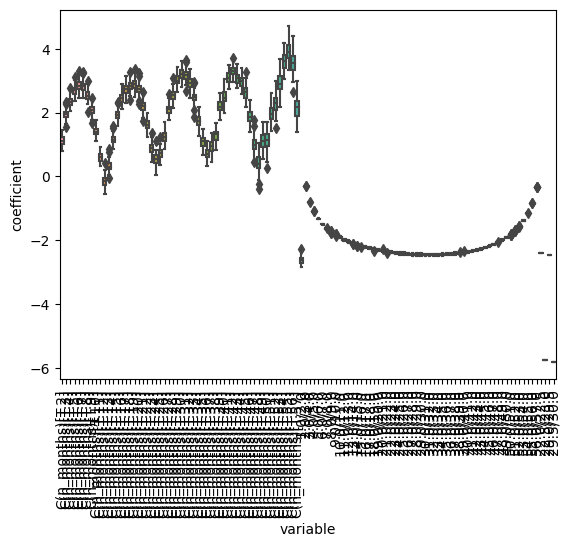

In [68]:
import matplotlib.pyplot as plt
df = pd.DataFrame(rank_params)
sns.boxplot(data=df, x='variable', y='coefficient')
plt.xticks(rotation=90)

In [101]:
df = pd.DataFrame(dist_params)
cat_df = df[df['variable'].str.startswith("C(")].copy()
cat_df['variable_value'] = cat_df['variable'].apply(lambda v: v.split("T.")[-1].strip("]"))
cat_df['variable_name'] = cat_df['variable'].apply(lambda v: re.match("C\((.*)\)", v).group(1))

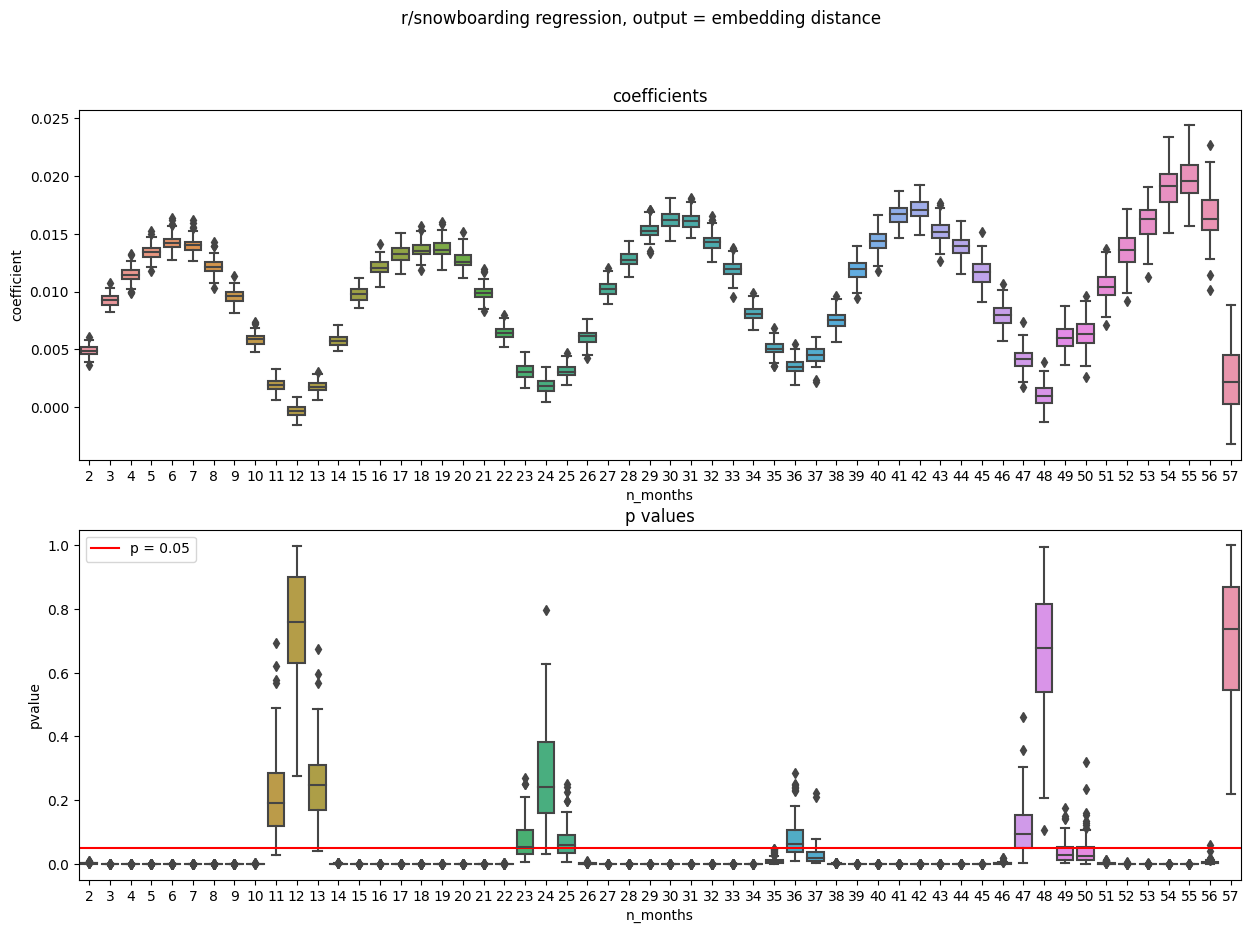

In [102]:
import matplotlib.pyplot as plt
df = pd.DataFrame(dist_params)
cat_df = df[df['variable'].str.startswith("C(")].copy()
cat_df['variable_value'] = cat_df['variable'].apply(lambda v: v.split("T.")[-1].strip("]"))
cat_df['variable_name'] = cat_df['variable'].apply(lambda v: re.match("C\((.*)\)", v).group(1))

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle(f"r/{subreddit} regression, output = embedding distance")
ax = sns.boxplot(data=cat_df, x='variable_value', y='coefficient', ax= axes[0])
ax.set_xlabel("n_months")
ax.set_title(f"coefficients")

ax = sns.boxplot(data=cat_df, x='variable_value', y='pvalue', ax=axes[1])
ax.set_xlabel("n_months")
ax.set_title(f"p values")
ax.axhline(0.05, color='red', label='p = 0.05')
plt.legend()
plt.savefig(f"./figures/{subreddit}-emb-regression.jpg", bbox_inches='tight')

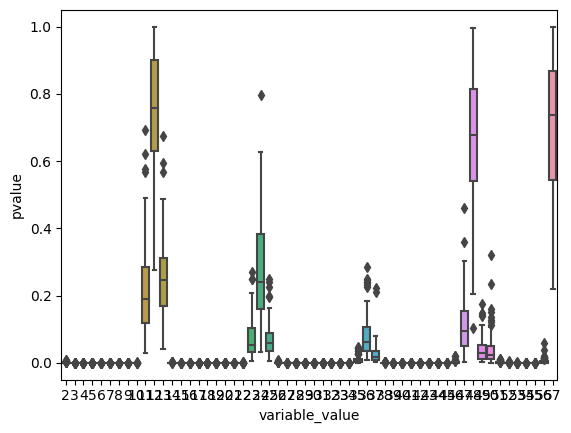

In [89]:
ax = sns.boxplot(data=cat_df, x='variable_value', y='pvalue')

## JSD 

In [2]:
import ngrams
import jsd

In [3]:
subreddit = 'tennis'
metadata = pk.load(open(f"./data/samples/{subreddit}-comments.pk", "rb"))

<AxesSubplot: xlabel='year-month'>

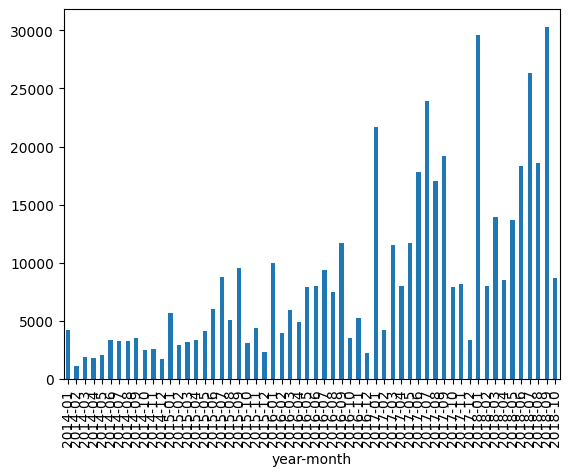

In [35]:
pd.DataFrame(list(metadata)).groupby('year-month').size().plot.bar()

<AxesSubplot: xlabel='year-month'>

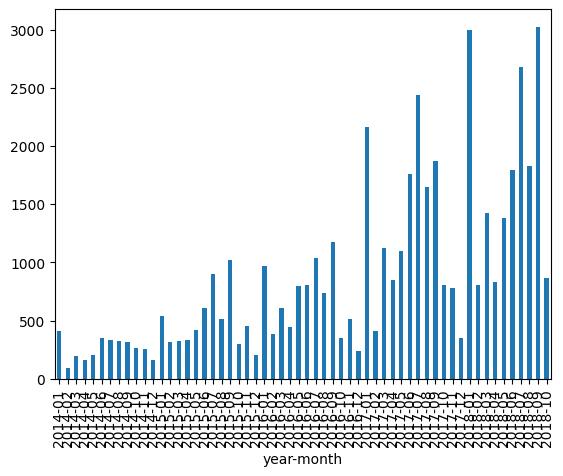

In [34]:
pd.DataFrame(list(sample_meta)).groupby('year-month').size().plot.bar()

In [49]:
# full
full = pk.load(open(f"./data/{subreddit}-comments.pk", "rb"))

full['year'] = full['year-month'].apply(lambda t: int(t.split("-")[0]))
full = full[full['year'] >= 2014].copy()
full_data = np.array(full.to_dict(orient='records'))

<AxesSubplot: xlabel='month_1', ylabel='month_2'>

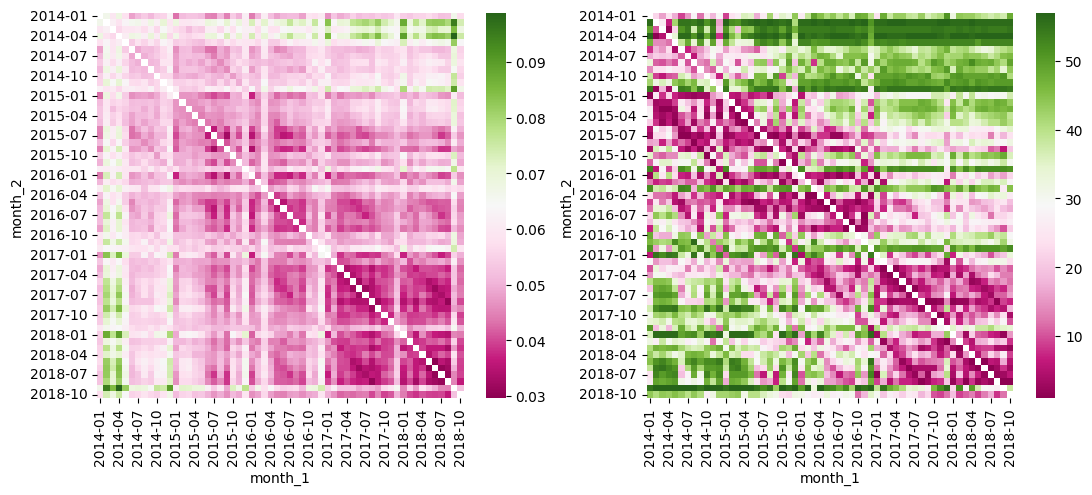

In [55]:
ngrams_counter = ngrams.get_ngrams_counter(utts = full_data)
months, dist, long = jsd.run(ngrams_counter)

fig, axes=plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(pd.DataFrame.pivot(long, index='month_2', columns='month_1', values='jsd'),cmap='PiYG', ax=axes[0])
sns.heatmap(pd.DataFrame.pivot(long, index='month_2', columns='month_1', values='jsd_rank'),cmap='PiYG', ax=axes[1])

<AxesSubplot: xlabel='month_1', ylabel='month_2'>

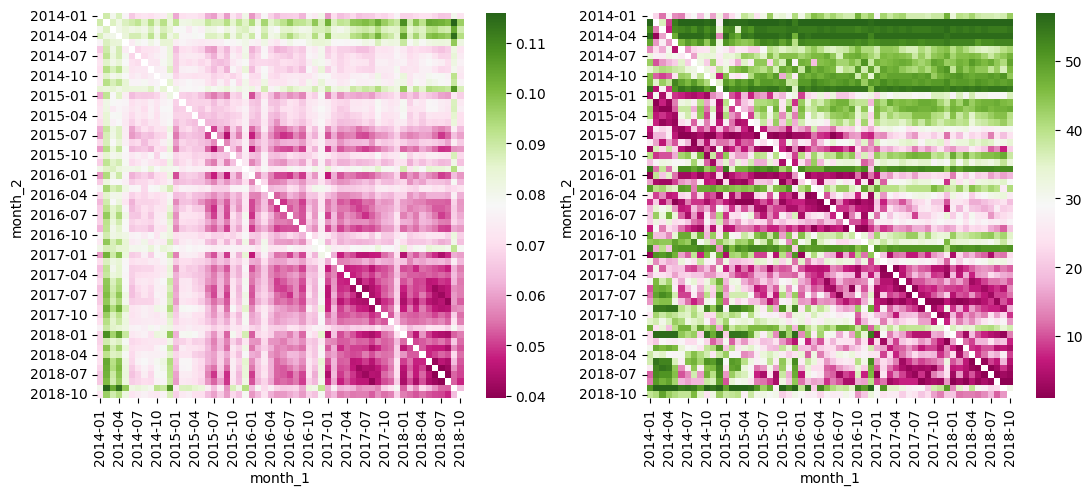

In [54]:
# sample
ngrams_counter = ngrams.get_ngrams_counter(utts = metadata)
months, dist, long = jsd.run(ngrams_counter)

fig, axes=plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(pd.DataFrame.pivot(long, index='month_2', columns='month_1', values='jsd'),cmap='PiYG', ax=axes[0])
sns.heatmap(pd.DataFrame.pivot(long, index='month_2', columns='month_1', values='jsd_rank'),cmap='PiYG', ax=axes[1])

<AxesSubplot: xlabel='month_1', ylabel='month_2'>

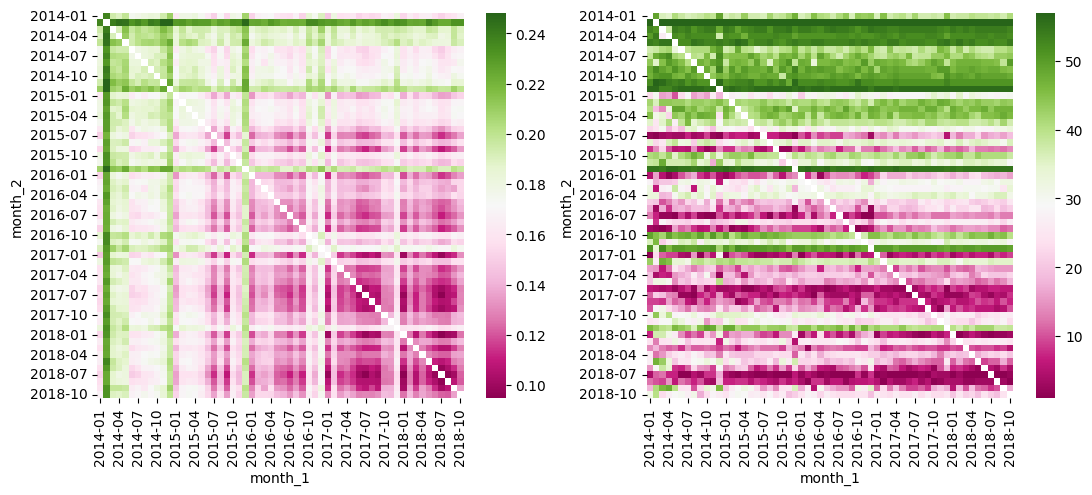

In [53]:
# subsample
sample_idx = np.random.choice(len(metadata), size=50000, replace=True)
sample_meta = metadata[sample_idx]
ngrams_counter = ngrams.get_ngrams_counter(utts = sample_meta)
months, dist, long = jsd.run(ngrams_counter)

fig, axes=plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(pd.DataFrame.pivot(long, index='month_2', columns='month_1', values='jsd'),cmap='PiYG', ax=axes[0])
sns.heatmap(pd.DataFrame.pivot(long, index='month_2', columns='month_1', values='jsd_rank'),cmap='PiYG', ax=axes[1])

<AxesSubplot: xlabel='month_1', ylabel='month_2'>

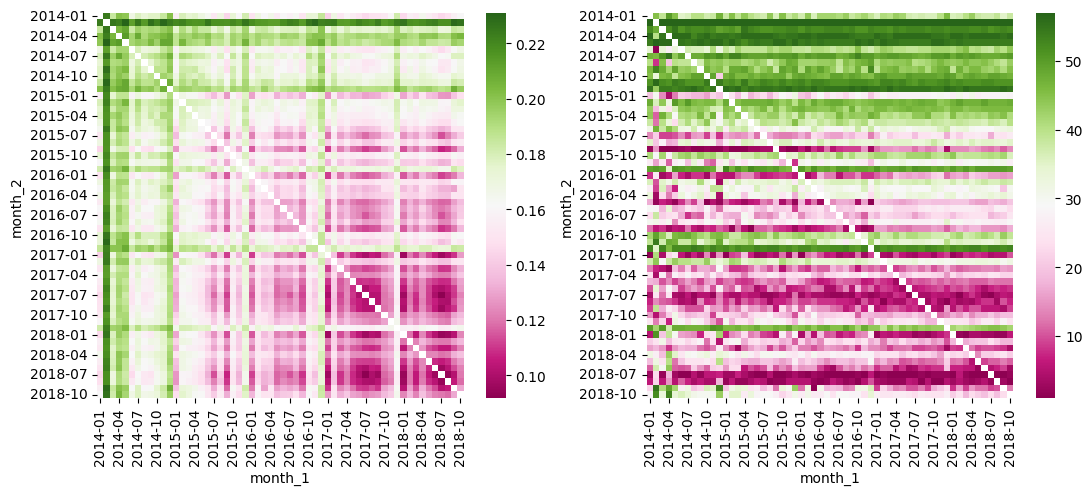

In [5]:
# subsample
sample_idx = np.random.choice(len(metadata), size=50000, replace=False)
sample_meta = metadata[sample_idx]
ngrams_counter = ngrams.get_ngrams_counter(utts = sample_meta)
months, dist, long = jsd.run(ngrams_counter)

fig, axes=plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(pd.DataFrame.pivot(long, index='month_2', columns='month_1', values='jsd'),cmap='PiYG', ax=axes[0])
sns.heatmap(pd.DataFrame.pivot(long, index='month_2', columns='month_1', values='jsd_rank'),cmap='PiYG', ax=axes[1])

In [12]:
import pickle as pk
rank_params = pk.load(open(f"./data/output/regression/AdviceAnimals-emb_params-O.pk", "rb"))

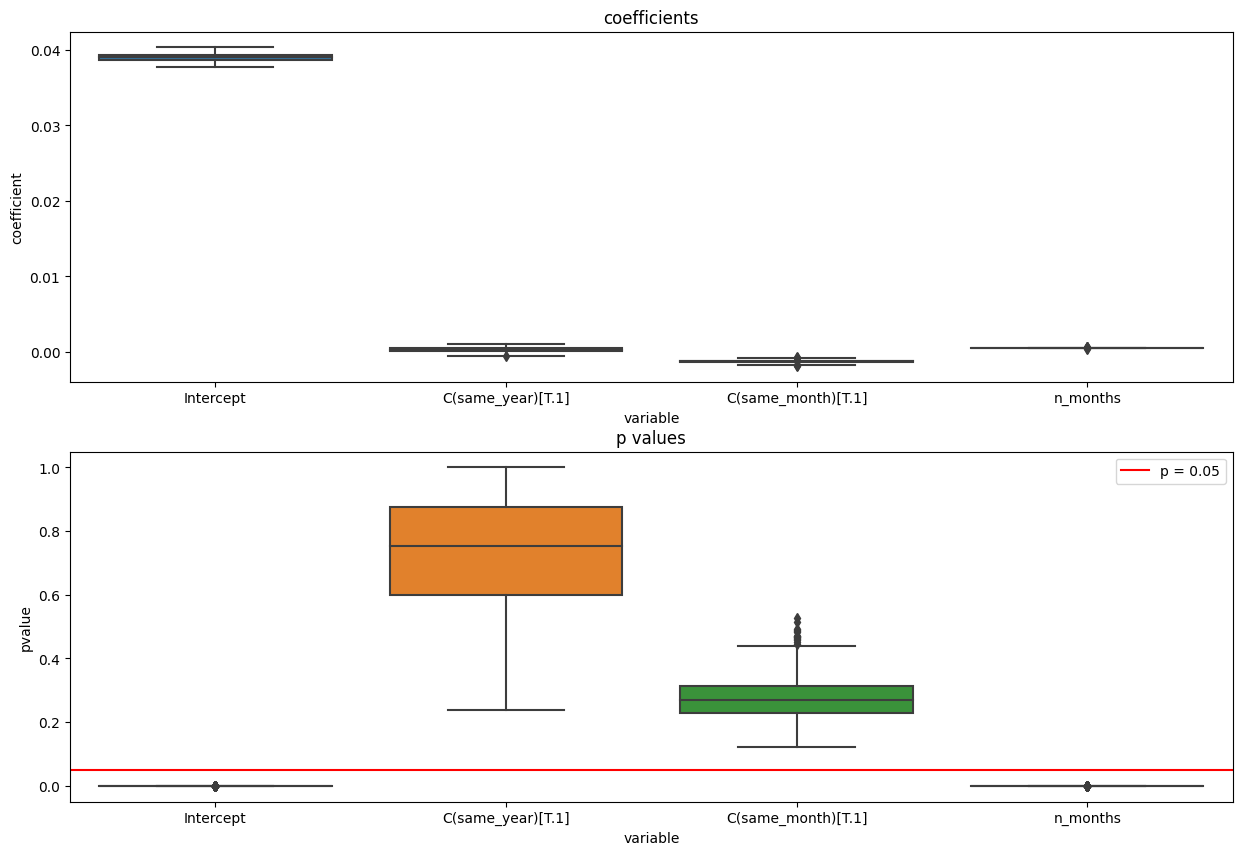

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df = pd.DataFrame(rank_params)
df = df[~df['variable'].str.contains("/")].copy()
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# fig.suptitle(f"r/{args.subreddit} regression, output = Rank by embedding distance")
ax = sns.boxplot(data=df, x='variable', y='coefficient', ax=axes[0])
ax.set_title("coefficients")

ax = sns.boxplot(data=df, x='variable', y='pvalue', ax=axes[1])
ax.set_title(f"p values")
ax.axhline(0.05, color='red', label='p = 0.05')
plt.legend()

In [4]:
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
import jsd
import ngrams
def run(metadata):
    sample_idx = np.random.choice(len(metadata), size=50000, replace=True)
    sample_meta = metadata[sample_idx]
    ## fill 
    ngrams_counter = ngrams.get_ngrams_counter(utts = sample_meta)
    long = jsd.run(ngrams_counter)
    ## 
    long['same_year'] = long.apply(lambda r: 1 if r['month_1'].split("-")[0] == r['month_2'].split("-")[0] else 0, axis=1)
    long['same_month'] = long.apply(lambda r: 1 if r['month_1'].split("-")[1] == r['month_2'].split("-")[1] else 0, axis=1)
    long['months_apart'] = long.apply(lambda r: 
                                      np.abs(relativedelta.relativedelta(parse(r['month_2']), parse(r['month_1'])).months),
                                     axis=1)
    
    scaler = preprocessing.MinMaxScaler()
    norms = scaler.fit_transform(long[['jsd', 'jsd_rank', "months_apart"]].values)
    long['normalized_jsd'] = norms[:, 0]
    long['normalized_jsd_rank'] = norms[:, 1]
    long['normalized_months_apart'] = norms[:, 2]
    mod = smf.ols(formula='normalized_jsd ~ C(same_year) + C(same_month) + normalized_months_apart', data=long.dropna())
    jsd_res = mod.fit()
    
    mod = smf.ols(formula='normalized_jsd_rank ~ C(same_year) + C(same_month) + normalized_months_apart', data=long.dropna())
    rank_res = mod.fit()
    return jsd_res, rank_res

In [9]:
rank_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     normalized_jsd_rank   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     2.689
Date:                 Fri, 24 Feb 2023   Prob (F-statistic):             0.0448
Time:                         12:10:50   Log-Likelihood:                -637.43
No. Observations:                 3306   AIC:                             1283.
Df Residuals:                     3302   BIC:                             1307.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.5206      0.012     43.650      0.000       0.497       0.544
C(same_year)[T.1]          -0.0324      0.014     -2.390      0.017      -0.059      -0.006
C(same_month)[T.1]         -0.0461      0.023     -2.007      0.045      -0.091      -0.001
normalized_months_apart    -0.0240      0.019     -1.261      0.207      -0.061       0.013
==============================================================================
Omnibus:                     2728.336   Durbin-Watson:                   0.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.952
Skew:                           0.003   Prob(JB):                     1.04e-43
Kurtosis:                       1.801   Cond. No.                         6.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
dist_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         normalized_jsd   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.901
Date:                Fri, 24 Feb 2023   Prob (F-statistic):            0.00855
Time:                        12:10:10   Log-Likelihood:                 870.50
No. Observations:                3306   AIC:                            -1733.
Df Residuals:                    3302   BIC:                            -1709.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4362      0.008     57.701      0.000       0.421       0.451
C(same_year)[T.1]          -0.0162      0.009     -1.882      0.060      -0.033       0.001
C(same_month)[T.1]         -0.0451      0.015     -3.101      0.002      -0.074      -0.017
normalized_months_apart    -0.0265      0.012     -2.203      0.028      -0.050      -0.003
==============================================================================
Omnibus:                       77.884   Durbin-Watson:                   0.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.066
Skew:                           0.243   Prob(JB):                     9.05e-14
Kurtosis:                       2.553   Cond. No.                         6.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
from collections import defaultdict
from tqdm import tqdm
dist_params = defaultdict(list)
rank_params = defaultdict(list)

for i in tqdm(range(300)):
    dist_res, rank_res = run(metadata)

    for k, v in dist_res.params.to_dict().items():
        dist_params[k].append(v)

    for k, v in rank_res.params.to_dict().items():
        rank_params[k].append(v)

  1%|▉                                                                                                                                              | 2/300 [01:29<3:41:22, 44.57s/it]


KeyboardInterrupt: 

## plot

In [2]:
subreddits = ['AdviceAnimals', 'AmItheAsshole', 'Android', 'AskMen', 'Bitcoin', 'Buddhism', 'CFB', 'Christianity', 'DebateReligion', 'Diablo', 'Drugs', 'Economics', 'Fitness', 'Frugal', 'Games', 'IAmA', 'Judaism', 'LifeProTips', 'MMA', 'MakeupAddiction', 'Marvel', 'MensRights', 'Minecraft', 'MovieDetails', 'Music', 'Naruto', 'Random_Acts_Of_Amazon', 'ShingekiNoKyojin', 'SquaredCircle', 'WTF', 'anime', 'apple', 'atheism', 'australia', 'baseball', 'books', 'business', 'canada', 'cars', 'conspiracy', 'cringe', 'cringepics', 'dayz', 'electronic_cigarette', 'explainlikeimfive', 'fantasyfootball', 'funny', 'gaming', 'gifs', 'guns', 'hiphopheads', 'hockey', 'leagueoflegends', 'magicTCG', 'malefashionadvice', 'motorcycles', 'movies', 'nba', 'news', 'nfl', 'photography', 'pics', 'pokemontrades', 'politics', 'programming', 'relationship_advice', 'relationships', 'science', 'sex', 'singapore', 'skyrim', 'snowboarding', 'soccer', 'technology', 'techsupport', 'teenagers', 'tennis', 'tf2', 'tifu', 'todayilearned', 'travel', 'trees', 'unitedkingdom', 'videos', 'worldnews']

In [3]:
import pickle as pk
from adjustText import adjust_text

,variable,coefficient,pvalue
0,Intercept,0.473079,0.000000e+00
1,C(same_year)[T.1],-0.129227,2.263569e-60
2,C(same_month)[T.1],-0.007205,5.818427e-01
3,normalized_months_apart,0.008927,4.094106e-01
4,Intercept,0.467105,0.000000e+00
...,...,...,...
1995,normalized_months_apart,0.014760,1.874054e-01
1996,Intercept,0.476889,0.000000e+00
1997,C(same_year)[T.1],-0.130256,1.968638e-61
1998,C(same_month)[T.1],-0.000611,9.626990e-01


In [21]:
stash = dict()
df = pd.DataFrame()
for subreddit in subreddits:
    params = pk.load(open(f"./data/output/regression/{subreddit}-emb_rank_params.pk", "rb"))
    one_subreddit = pd.DataFrame(params)
    one_subreddit['subreddit'] = subreddit
    df = pd.concat((df, one_subreddit))

In [22]:
df.head()

,variable,coefficient,pvalue,subreddit
0,C(same_year)[T.1],-1.392169,6.797242e-63,AdviceAnimals
1,C(same_month)[T.1],-0.098315,4.688699e-01,AdviceAnimals
2,months_apart,0.010745,2.881119e-01,AdviceAnimals
3,1.0/2.0,-4.414462,1.473749e-192,AdviceAnimals
4,2.0/3.0,-0.323620,1.440200e-02,AdviceAnimals


In [34]:
g = df.groupby(["subreddit", "variable"])['coefficient'].mean().reset_index()
g.head()

,subreddit,variable,coefficient
0,AdviceAnimals,1.0/2.0,-4.367346
1,AdviceAnimals,10.0/11.0,-2.003284
2,AdviceAnimals,11.0/12.0,-2.079066
3,AdviceAnimals,12.0/13.0,-2.145686
4,AdviceAnimals,13.0/14.0,-2.204414


<AxesSubplot: xlabel='variable', ylabel='coefficient'>

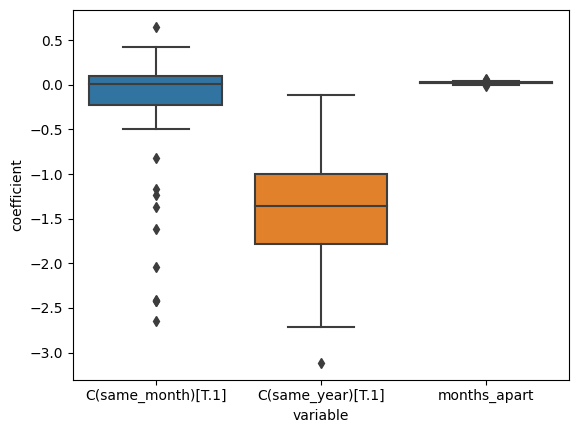

In [37]:
sns.boxplot(data=g[~g['variable'].str.contains("/")], x='variable', y='coefficient')

In [39]:
g = g.pivot(index='subreddit', columns='variable', values='coefficient')

237

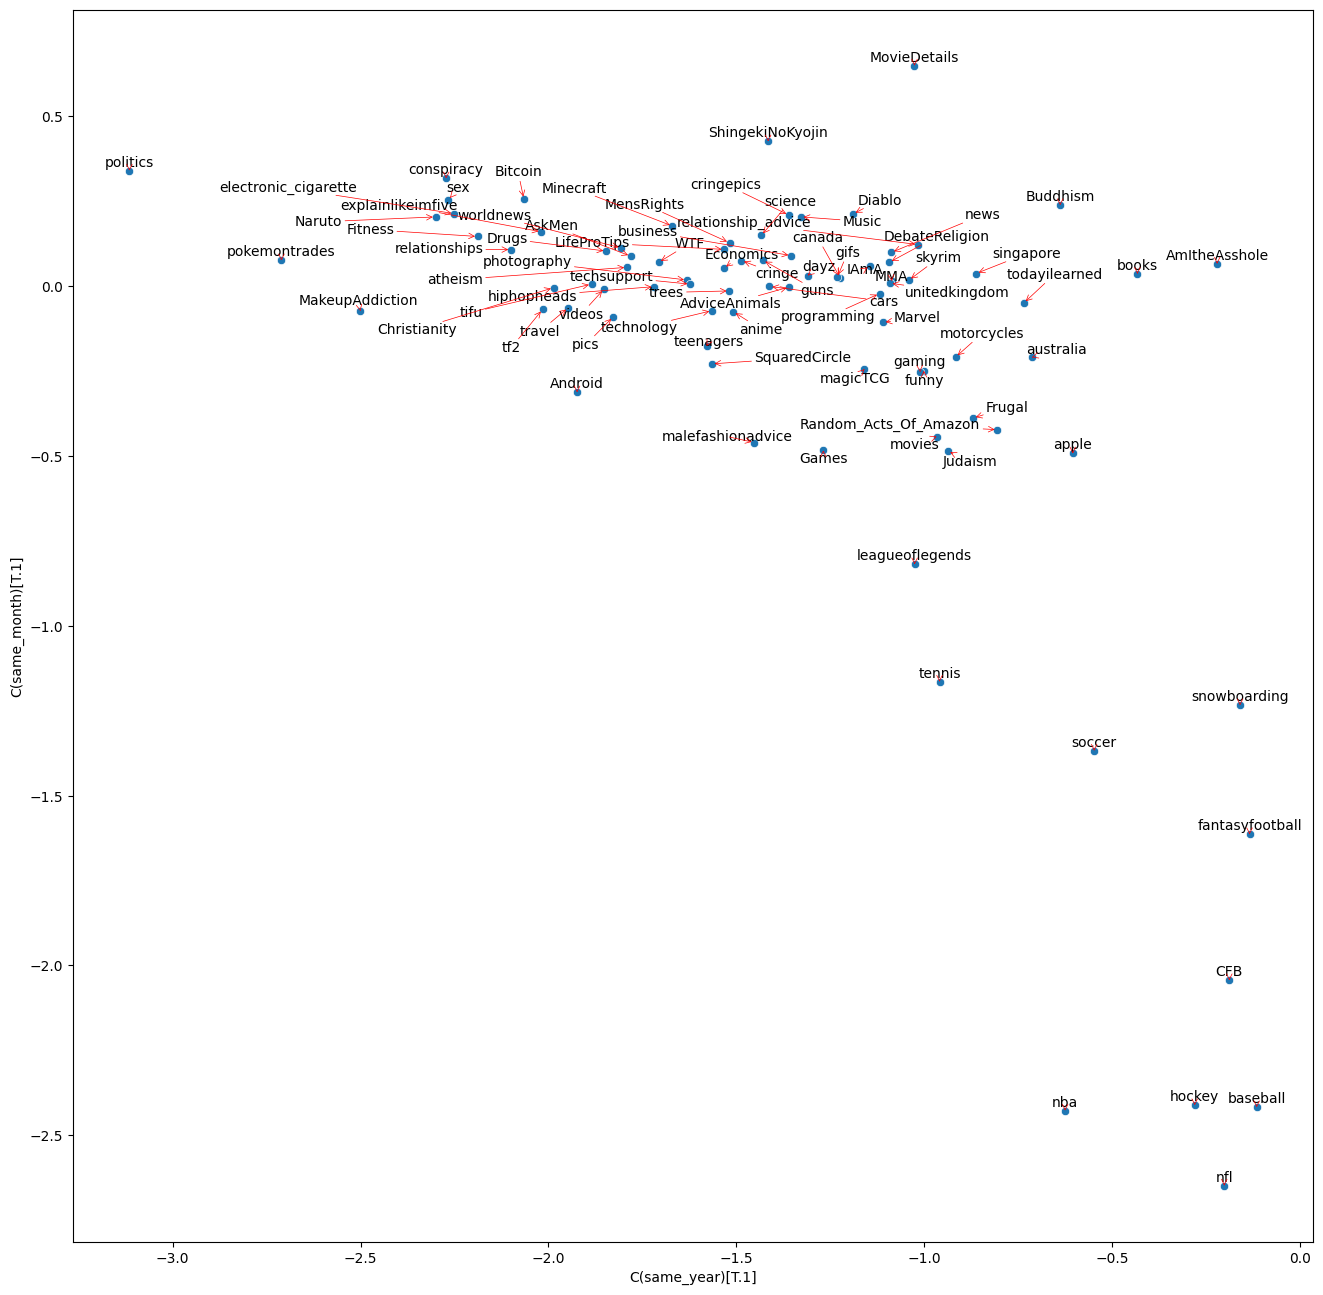

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
axis1 = "C(same_year)[T.1]"
axis2 = "C(same_month)[T.1]"
sns.scatterplot(data = g, x=axis1, y =axis2)

texts = []
for x, y, s in zip(g[axis1], g[axis2], g.index):
    texts.append(plt.text(x, y, s))
    
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, 
            autoalign='y',
            arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

85

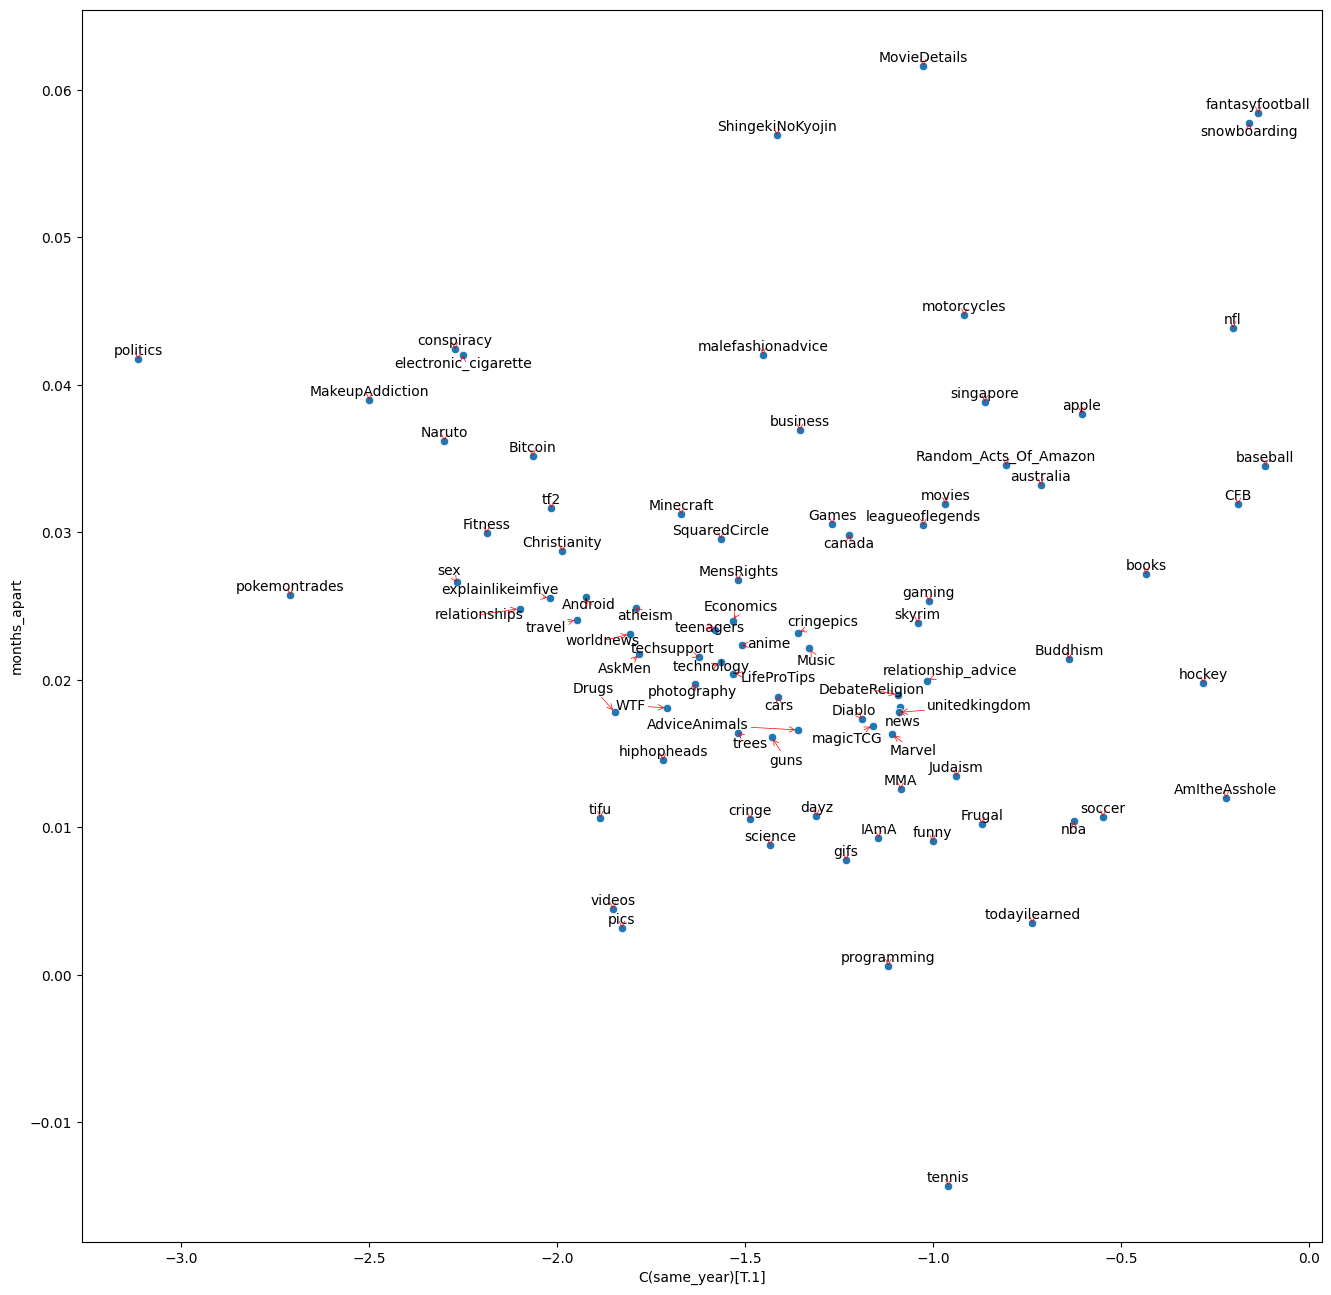

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
axis1 = "C(same_year)[T.1]"
axis2 = "months_apart"
sns.scatterplot(data = g, x=axis1, y =axis2)

texts = []
for x, y, s in zip(g[axis1], g[axis2], g.index):
    texts.append(plt.text(x, y, s))
    
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, 
            autoalign='y',
            arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

226

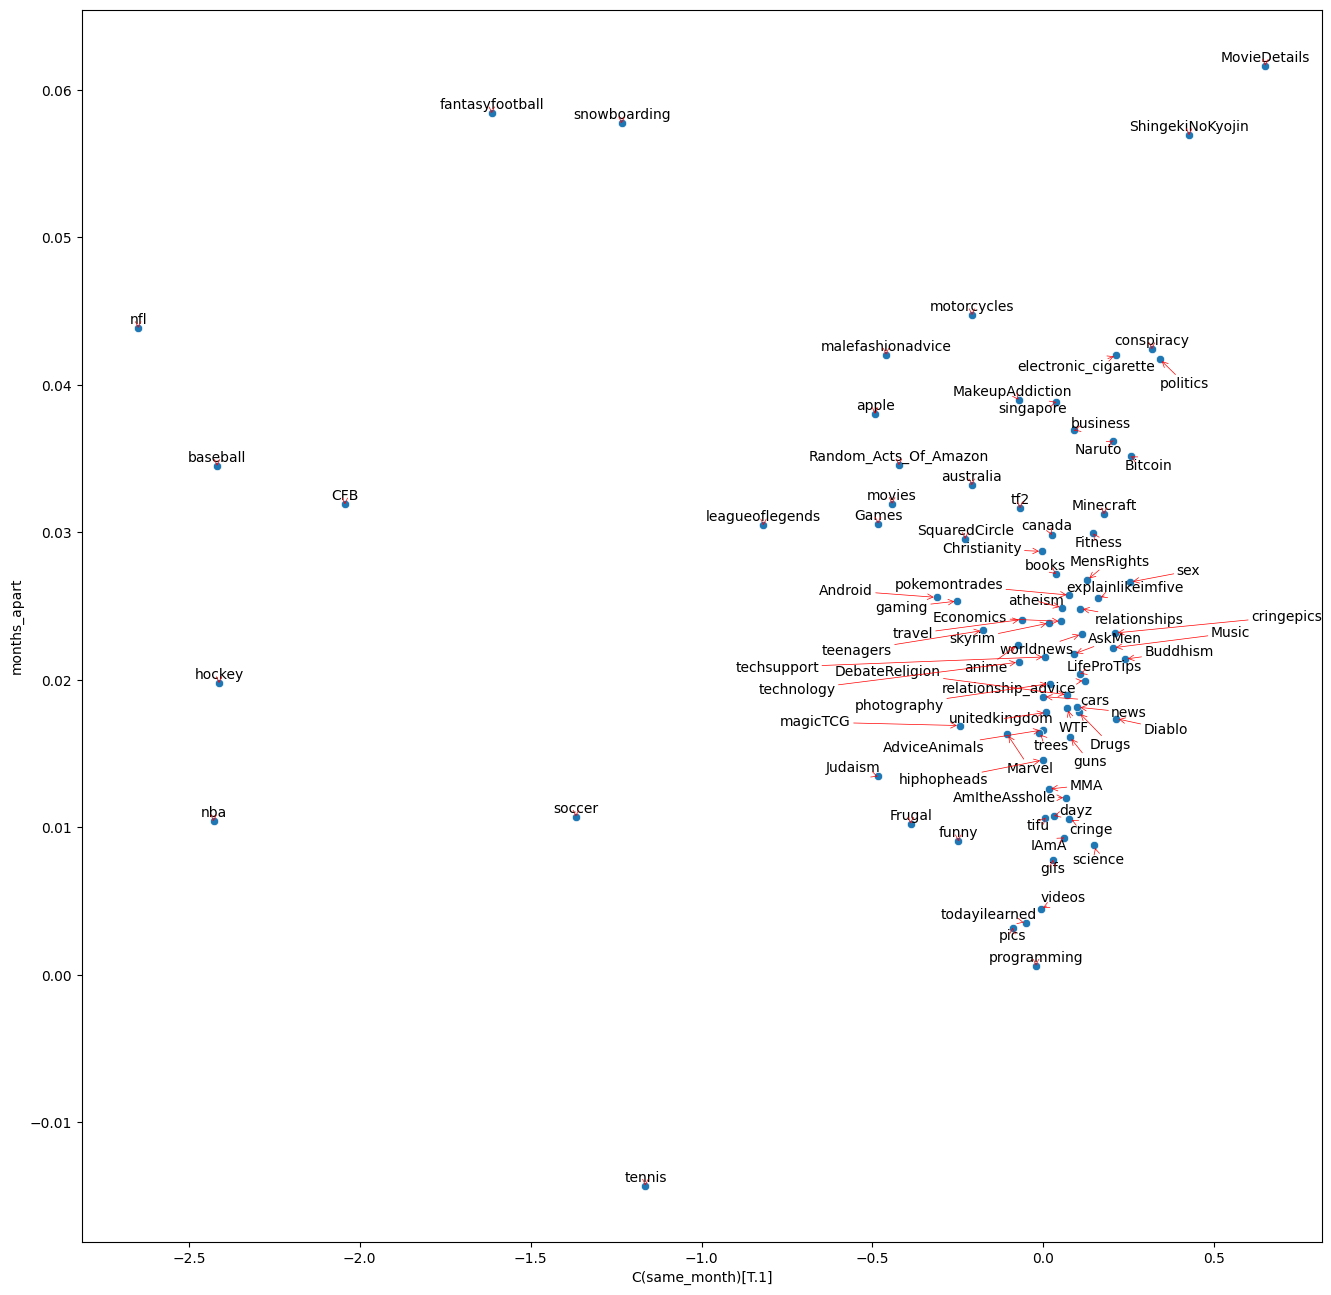

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
axis1 = "C(same_month)[T.1]"
axis2 = "months_apart"
sns.scatterplot(data = g, x=axis1, y =axis2)

texts = []
for x, y, s in zip(g[axis1], g[axis2], g.index):
    texts.append(plt.text(x, y, s))
    
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, 
            autoalign='y',
            arrowprops=dict(arrowstyle="->", color='r', lw=0.5))